**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [ ]:
print("Aboba")

Aboba


# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import seaborn as sns

# Fashion MNIST Classifier



## Data

In [3]:
X = dict()
y = dict()

n_val = 5000
(X['train'], y['train']), (X['test'], y['test']) = keras.datasets.fashion_mnist.load_data()
X['train'], X['val'] = ( (X/255.0).astype('float32') for X in (X['train'][n_val:], X['train'][:n_val]))
y['train'], y['val'] = y['train'][n_val:], y['train'][:n_val]

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
X['val'][0,5].dtype

dtype('float32')

In [5]:
print(f"""
X shape:{X['val'].shape[1:]}
y shape: 1
Dtype: {X['val'].dtype}
{'-'*54}""")

for split in X.keys():
    print(f"""{split.capitalize()}: {y[split].shape[0]}""")


X shape:(28, 28)
y shape: 1
Dtype: float32
------------------------------------------------------
Train: 55000
Test: 10000
Val: 5000


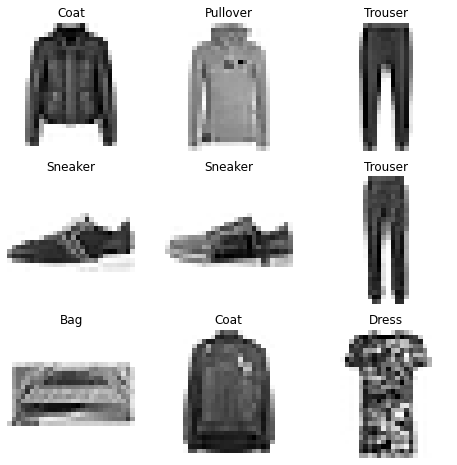

In [11]:
n_cols, n_rows = 3,3
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_classes = len(class_names)

def plot_random_items(n_cols = 3, n_rows = 3, cmap = 'binary'):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, n_cols * n_rows + 1):
        sample_idx = np.random.randint(X['train'].shape[0],size=(1,))[0]
        figure.add_subplot(n_rows, n_cols, i)
        plt.title(class_names[y['train'][sample_idx]])
        plt.axis("off")
        plt.imshow(X['train'][sample_idx], cmap=cmap, interpolation='nearest')
    plt.show()

plot_random_items()

## Model

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=X['val'].shape[1:]),
    keras.layers.Dense(350, activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(n_classes, activation='softmax')]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 350)               274750    
                                                                 
 dropout_1 (Dropout)         (None, 350)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               35100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 310,860
Trainable params: 310,860
Non-trainable params: 0
_________________________________________________________________


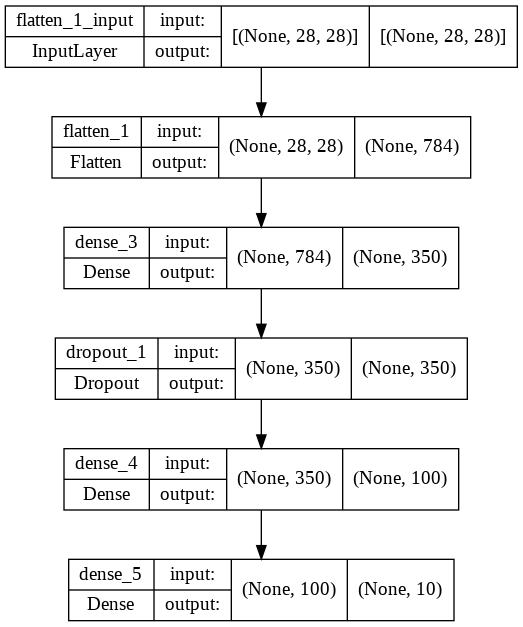

In [14]:
plot_model(model,show_shapes=True,show_dtype=not True)

In [15]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [35]:
history = model.fit(X['train'],y['train'],
          validation_data = (X['val'], y['val']),
          epochs = 30,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=3)])

Epoch 1/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2452 - accuracy: 0.9122 - val_loss: 0.2908 - val_accuracy: 0.8982
Epoch 2/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2423 - accuracy: 0.9117 - val_loss: 0.2886 - val_accuracy: 0.8964
Epoch 3/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2402 - accuracy: 0.9129 - val_loss: 0.2888 - val_accuracy: 0.8970
Epoch 4/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2380 - accuracy: 0.9149 - val_loss: 0.2880 - val_accuracy: 0.8976
Epoch 5/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2391 - accuracy: 0.9144 - val_loss: 0.2865 - val_accuracy: 0.8988
Epoch 6/30
430/430 [==============================] - 4s 8ms/step - loss: 0.2359 - accuracy: 0.9146 - val_loss: 0.2860 - val_accuracy: 0.8986
Epoch 7/30
430/430 [==============================] - 4s 9ms/step - loss: 0.2335 - accuracy: 0.9150 - val_loss: 0.2871 - val_accuracy: 0.8960
Epoch 

In [38]:
weights, biases = model.layers[1].get_weights()
print(f"""Fully Connected[1]:
weights shape: {weights.shape}
biases shape: {biases.shape}
""")

Fully Connected[1]:
weights shape: (784, 350)
biases shape: (350,)



In [41]:
model.evaluate(X['test'],y['test'])

313/313 [==============================] - 1s 3ms/step - loss: 61.2090 - accuracy: 0.8507


[61.20903778076172, 0.8507000207901001]